# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment:<br><br>
Run the cell below <strong>5. Close the environment</strong>.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from dqn_agent import DQNAgent
from dqn_gridsearch import DQNGridsearch

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def formatEpisodeScore(i_episode, moving_avg_score):
    """Returns a formatted episode result.
        
        Params
        ======
        i_episode (int): episode index
        moving_avg_score (float): a score value
    """
    return f"Episode: {i_episode}\tMoving average score: {moving_avg_score:.2f}"

In [9]:
def plot_scores(scores):
    """Plots a score list.
        
        Params
        ======
        scores (array): a score list
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [10]:
def dqn(agent, n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
       every_nth_episode=100, moving_avg_size=100, min_avg_score=13):

    """ Trains a DQNAgent to solve the environment.
        
        Params
        ======
        agent (DQNAgent): an dqn agent
        n_episodes (int): number of episodes
        max_t (int): max number of episode steps
        eps_start (float): start value for epsilon-greedy action selection
        eps_end (float): minimum value for epsilon-greedy action selection
        eps_decay (float): epsilon-greedy decay value
        every_nth_episode (int): prints the score of every nth epsiode
        moving_avg_size (int): the window size for calculationg the average score
        min_avg_score (float): the minimum moving average score
        
        Returns
        ======
        scores (array): a list of all episode score
        moving_avg_score (array): the last calculated moving average score
        needed_epsiodes (int): the number of episodes to solve the environment
    """
    
    scores = []
    scores_window = deque(maxlen=moving_avg_size)
    needed_epsiodes = 0
    eps = eps_start 

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0                     

        for t in range(max_t):
            action = agent.act(state, eps)  
            env_info = env.step(action)[brain_name]        # send the action to the environment
            
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break   
            
        scores_window.append(score)
        scores.append(score)
        moving_avg_score = np.mean(scores_window)
        eps = max(eps_end, eps_decay*eps)

        if i_episode % every_nth_episode == 0:
            print(formatEpisodeScore(i_episode, moving_avg_score))
        if moving_avg_score >= min_avg_score:
            formattedEpisodeScore = formatEpisodeScore(i_episode, moving_avg_score)
            print(f"{formattedEpisodeScore}\tEnvironment solved!")
            needed_epsiodes = i_episode
            break
        if (i_episode+1 == n_episodes+1) and (moving_avg_score < min_avg_score):
            formattedEpisodeScore = formatEpisodeScore(i_episode, moving_avg_score)
            print(f"{formattedEpisodeScore}\tEnvironment not solved!")

    return scores, moving_avg_score, needed_epsiodes    

In [11]:
moving_avg_size = 100
min_avg_score = 13
print(f"Moving average size: {moving_avg_size}")
print(f"Minimum moving average score: {min_avg_score}")

Moving average size: 100
Minimum moving average score: 13


### 4.1 Learning Algorithm
The environment was solved with the DQN algorithm. <br>
<br>
The actor model uses three linear layers with an input size of 37 (for every state), a hidden layer size of 64 and an output size of 4 (for every action).

In [12]:
dqn_gridsearch = DQNGridsearch()
dqn_hyperparameters = dqn_gridsearch.create_gridsearch_params() #create a grid search hyperparameters list

print("DQNGridsearch hyperparameters:")
print(dqn_gridsearch)
print()
dqn_params_len = len(dqn_hyperparameters)

n_episodes = 600
every_nth_episode = 200
best_scores = []
best_avg_score = 0
best_needed_epsiodes = 0
best_dqn_params = None

for idx, dqn_params in enumerate(dqn_hyperparameters): #for every DQNHyperparameters object 
    print(f"DQNHyperparameters: {idx+1}/{dqn_params_len}")
    print(dqn_params)
    agent = DQNAgent(device, dqn_params, state_size, action_size, seed=0)
    scores, moving_avg_score, needed_epsiodes = dqn(agent=agent, n_episodes=n_episodes, 
                                                    every_nth_episode=every_nth_episode, 
                                                    moving_avg_size=moving_avg_size, min_avg_score=min_avg_score)

    if (moving_avg_score >= best_avg_score): # find the best moving average score
        best_scores = scores
        best_needed_epsiodes = needed_epsiodes
        best_avg_score = moving_avg_score
        best_dqn_params = dqn_params
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # save the best model weigths
    print()
    
print("Best DQNHyperparameters:")
print(best_dqn_params)
print(f"Best moving average score: {best_avg_score:.2f}. Solved in {best_needed_epsiodes} episodes.")

DQNGridsearch hyperparameters:
lr: [0.0005, 0.005]
gamma: [0.99, 0.1]

DQNHyperparameters: 1/4
lr: 0.0005
gamma: 0.99
buffer_size: 100000
batch_size: 64
tau: 0.001
update_every: 4
Episode: 200	Moving average score: 3.93
Episode: 400	Moving average score: 10.02
Episode: 476	Moving average score: 13.00	Environment solved!

DQNHyperparameters: 2/4
lr: 0.0005
gamma: 0.1
buffer_size: 100000
batch_size: 64
tau: 0.001
update_every: 4
Episode: 200	Moving average score: 0.46
Episode: 400	Moving average score: 0.44
Episode: 600	Moving average score: 0.25
Episode: 600	Moving average score: 0.25	Environment not solved!

DQNHyperparameters: 3/4
lr: 0.005
gamma: 0.99
buffer_size: 100000
batch_size: 64
tau: 0.001
update_every: 4
Episode: 200	Moving average score: 2.46
Episode: 400	Moving average score: 6.08
Episode: 600	Moving average score: 10.14
Episode: 600	Moving average score: 10.14	Environment not solved!

DQNHyperparameters: 4/4
lr: 0.005
gamma: 0.1
buffer_size: 100000
batch_size: 64
tau: 0.00

### 4.2 Solution
The environment could be solved in epsiode 476 with a learning rate of 0.0005 and gamm value of 0.99.

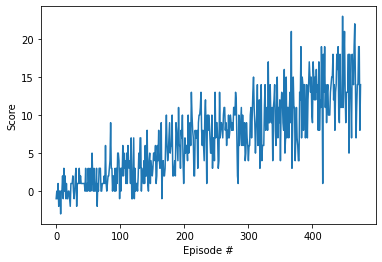

In [13]:
plot_scores(best_scores)

### 4.3 Improvements
The agent's performance could be improved with an implementation of a doubleDQN, dueling DQN or prioritized experience replay.

### 5. Close the environment

In [14]:
env.close()